<br><br><br><br><br>

# PyROOT: ROOT in Python

<br><br><br><br><br>

<br><br>

<p style="font-size: 1.25em">Show of hands:</p>

   1. Who hasn't heard of ROOT?
   2. Who hasn't heard of PyROOT?
   3. Who hasn't ever used PyROOT?
   4. Who doesn't use PyROOT regularly?

<br><br>

Welcome to JupyROOT 6.17/01


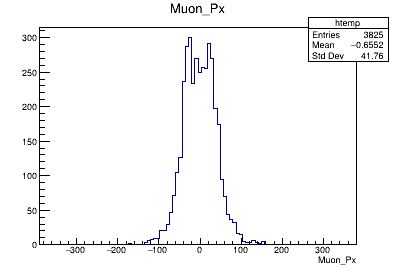

In [1]:
import ROOT                                      # PyROOT

file = ROOT.TFile("data/HZZ.root")               # PyROOT transliterates C++ syntax to Python
tree = file.Get("events")

canvas = ROOT.TCanvas("canvas", "", 400, 300)    # Jupyter-ROOT only: need to create TCanvas
tree.Draw("Muon_Px")
canvas.Draw()                                    # and Draw it to see plots inline

Another Jupyter-ROOT feature: C++ cells!



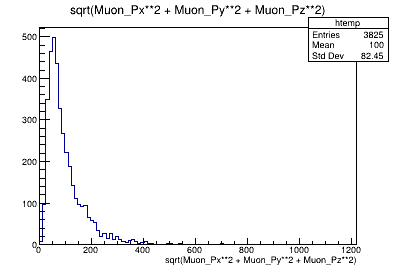

In [2]:
%%cpp

std::cout << "Another Jupyter-ROOT feature: C++ cells!" << std::endl << std::endl;

events->Draw("sqrt(Muon_Px**2 + Muon_Py**2 + Muon_Pz**2)");
canvas->Draw();

In [3]:
%%cpp -d

double define_cpp_functions(double a, double b) {
    return a + b;
}

In [4]:
# ... that you can use on both sides of the divide.

ROOT.define_cpp_functions(3.14, 100)

103.14

In [5]:
# PyROOT's ability to bind any C++ function to Python, without user intervention,
# is unique and far-reaching.
# 
# Even if you're not in Jupyter (i.e. a script running in a batch job), you can use it:

ROOT.gInterpreter.Declare(r"""
double another_cpp_function(double x) {
    return x*x*x;
}
""")

ROOT.another_cpp_function(123)

1860867.0

In [31]:
# Unfortunately, you can't redefine C++ functions, which makes interactive work difficult.
# 
# Here's what I do:

pyname = "cpp_func"
cppname = pyname + "_%d" % sum(1 if x.startswith(pyname) else 0 for x in dir(ROOT))
ROOT.gInterpreter.Declare(r"""

double """ + cppname + r"""(double x) {
    return x*x;
}

""")
exec(f"{pyname} = ROOT.{cppname}")

cpp_func(5)

25.0

In [6]:
# Most importantly, you can pass Numpy arrays.
# The bridge might be slow, but you can move a lot of data at once by casting an array,
# then do work on the C++ side.

import numpy
values = numpy.arange(1000001, dtype=numpy.float32)

ROOT.gInterpreter.Declare(r"""
void cpp_on_numpy(int how_many, float* values) {
    for (int i = 0;  i < how_many;  i++) {
        values[i] = sqrt(values[i]);
    }
}
""")

ROOT.cpp_on_numpy(len(values), values)
values

array([   0.       ,    1.       ,    1.4142135, ...,  999.999    ,
        999.9995   , 1000.       ], dtype=float32)

In [7]:
# A raw C array interface is a little dangerous because the wrong len(values) will seg-fault.
# Use std::vectors instead.

a_vector = ROOT.std.vector("float")(1000001)
a_array = numpy.asarray(a_vector)

# a_array is viewing the same data as a_vector: changing one changes the other.
a_array[:] = numpy.arange(1000001, dtype=numpy.float32)

list(a_vector[:10])

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

<br><br>

<p style="font-size: 2em; font-weight: bold">Reminder:</p>

<br>

<center><img src="img/numpy-memory-layout.png" width="75%"></center>

<br><br>

In [12]:
ROOT.gInterpreter.Declare(r"""
std::vector<double> cpp_on_vector(std::vector<float> &a_vector) {
    std::vector<double> out;
    out.reserve(a_vector.size());
    for (auto x : a_vector) {
        out.push_back(sqrt(x));
    }
    return out;
}
""")

numpy.asarray(ROOT.cpp_on_vector(a_vector))

array([   0.        ,    1.        ,    1.41421354, ...,  999.99902344,
        999.99951172, 1000.        ])

In [14]:
# Unlike arrays created by Numpy, vectors are "owned" by C++.
# They'll stay in memory until deleted in ROOT, and Numpy isn't informed (potential for seg-faults.)

a_array.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [18]:
# For example, clearing and shrinking the vector frees its memory for other data to be allocated.
# Numpy doesn't know this and continues to look at those bytes, regardless of what they might contain.
# 
# Accessing the array (e.g. printing on the screen) *might* cause a seg-fault.
# Changing the array values *would likely* cause a seg-fault (or worse: corrupt data).

a_vector.clear()
a_vector.shrink_to_fit()

len(a_vector), a_vector.capacity(), len(a_array)

(0, 0, 1000001)